# Digit recognition


We use a convolutional neural network to recognize the digits of the MNIST database.


In [1]:
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline  

import tensorflow as tf

In [2]:
train = pd.read_csv("/Users/enricofonda/Data_science/train_digit.csv")
test = pd.read_csv("/Users/enricofonda/Data_science/test_digit.csv")
print(train.head())

train_data = train.iloc[:,1:].values
label = train['label'].values
test_data = test.values

   label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0      1       0       0       0       0       0       0       0       0   
1      0       0       0       0       0       0       0       0       0   
2      1       0       0       0       0       0       0       0       0   
3      4       0       0       0       0       0       0       0       0   
4      0       0       0       0       0       0       0       0       0   

   pixel8    ...     pixel774  pixel775  pixel776  pixel777  pixel778  \
0       0    ...            0         0         0         0         0   
1       0    ...            0         0         0         0         0   
2       0    ...            0         0         0         0         0   
3       0    ...            0         0         0         0         0   
4       0    ...            0         0         0         0         0   

   pixel779  pixel780  pixel781  pixel782  pixel783  
0         0         0         0         0         

In [3]:
# Normalize data
train_data = train_data / 255.0
test_data = test_data / 255.0

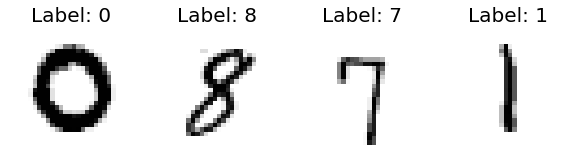

In [4]:
img = [1, 20, 50, 1000]

figs, axes = plt.subplots(1, 4, figsize=(10, 2.5))
for i in range(4):
    axes[i].imshow(-train_data[img[i]].reshape(28, 28), cmap = 'gray', interpolation = 'none')
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].set_title("Label: {}".format(label[img[i]]), fontsize = 20)
    axes[i].axis('off')

In [5]:
print(label)
num_labels = 10
labels = (np.arange(num_labels) == label[:,None]).astype(np.float32)
print(labels)

[1 0 1 ..., 7 6 9]
[[ 0.  1.  0. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]
 [ 0.  1.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  1.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  1.]]


In [6]:
# Randomize data
np.random.seed(133)

def randomize(dataset, label):
  permutation = np.random.permutation(label.shape[0])
  shuffled_dataset = dataset[permutation,:]
  shuffled_labels = label[permutation]
  return shuffled_dataset, shuffled_labels

total_train_dataset, total_train_labels = randomize(train_data, label)

Divide the training set in a smaller training set and a test set.

In [7]:
# Create Validation and test set

test_dataset = total_train_dataset[:5000]
test_labels = total_train_labels[:5000]

train_dataset = total_train_dataset[5000:]
train_labels = total_train_labels[5000:]


In [8]:
print(train_dataset.shape)
print(total_train_dataset.shape)

(37000, 784)
(42000, 784)


# Tensorflow

In [9]:
x = tf.placeholder(tf.float32, [None, 784])
W = tf.Variable(tf.zeros([784, 10]))
b = tf.Variable(tf.zeros([10]))
y = tf.nn.softmax(tf.matmul(x, W) + b)
y_ = tf.placeholder(tf.float32, [None, 10])

def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

In [10]:
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])

x_image = tf.reshape(x, [-1,28,28,1])

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

In [11]:
cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))

train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))

accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

predict = tf.argmax(y_conv,1)


In [12]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

batch_size = 100
for i in range(300):
  
  offset = (i * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
  batch_data = train_dataset[offset:(offset + batch_size), :]
  batch_labels = train_labels[offset:(offset + batch_size)]  
  batch_labels_1h = pd.get_dummies(batch_labels).as_matrix()
  
  if i%100 == 0:
    train_accuracy = accuracy.eval(feed_dict={
        x:batch_data, y_: batch_labels_1h, keep_prob: 1.0})
    print("step %d, training accuracy %g"%(i, train_accuracy))
  train_step.run(feed_dict={x: batch_data, y_: batch_labels_1h, keep_prob: 0.5})

test_labels_1h = pd.get_dummies(test_labels).as_matrix()
print("test accuracy %g"%accuracy.eval(feed_dict={
    x: test_dataset, y_: test_labels_1h, keep_prob: 1.0})) 

step 0, training accuracy 0.08
step 100, training accuracy 0.86
step 200, training accuracy 0.96
test accuracy 0.9374


In [13]:
# Predict digits of the test set.
feed_dict = {x: test_dataset, keep_prob: 1.0}
predictions = y_conv.eval(feed_dict)

In [14]:
predicted_labels = tf.argmax(predictions,1).eval()
print(predicted_labels)

[7 8 3 ..., 3 3 1]


In [15]:
accuracy_2 = tf.equal(test_labels, predicted_labels).eval()
print(accuracy_2)
print('accuracy',tf.reduce_mean(tf.cast(accuracy_2, tf.float32)).eval())

[ True  True  True ...,  True  True  True]
accuracy 0.9374


Retrain the network on the whole train dataset "total_train_dataset".

In [59]:
batch_size = 100
for i in range(300):
  #batch = mnist.train.next_batch(50)
  
  offset = (i * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
  batch_data = total_train_dataset[offset:(offset + batch_size), :]
  batch_labels = total_train_labels[offset:(offset + batch_size)]  
  batch_labels_1h = pd.get_dummies(batch_labels).as_matrix()
  
  if i%100 == 0:
    train_accuracy = accuracy.eval(feed_dict={
        x:batch_data, y_: batch_labels_1h, keep_prob: 1.0})
    print("step %d, training accuracy %g"%(i, train_accuracy))
  train_step.run(feed_dict={x: batch_data, y_: batch_labels_1h, keep_prob: 0.5})

step 0, training accuracy 0.94
step 100, training accuracy 0.97
step 200, training accuracy 0.93


Recognize 28,000 images of the test set.

In [32]:
test_to_predict = test.as_matrix()
print(test_to_predict.shape)

(28000, 784)


In [61]:
feed_dict = {x: test_to_predict, keep_prob: 1.0}
predictions = y_conv.eval(feed_dict) 

In [64]:
predicted_labels = tf.argmax(predictions,1).eval()
#print(predictions)
print(predicted_labels)

[2 0 9 ..., 3 9 2]


In [63]:
np.savetxt('/Users/enricofonda/Data_science/submission_MNIST_tf.csv', 
           np.c_[range(1,len(predicted_labels)+1),predicted_labels],
           delimiter=',', 
           header = 'ImageId,Label', 
           comments = '', 
           fmt='%d')

# Keras
Re-classify the digit using a neural network build with Keras.

In [18]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils

In [26]:
train_dataset = train_dataset.reshape(train_dataset.shape[0], 28, 28,1)
print(train_dataset.shape)
test_dataset = test_dataset.reshape(test_dataset.shape[0], 28, 28,1)
print(test_dataset.shape)

train_labels_oh = np_utils.to_categorical(train_labels, 10)
print(train_labels_oh.shape)

test_labels_oh = np_utils.to_categorical(test_labels, 10)

(37000, 28, 28, 1)
(5000, 28, 28, 1)
(37000, 10)


In [20]:
# Define model

model = Sequential()
 
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28,28,1)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
 
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

# Compile model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               589952    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

In [21]:
train_dataset.shape

(37000, 28, 28, 1)

In [27]:
# Fit model on training data
model.fit(train_dataset, train_labels_oh, 
          batch_size=32, epochs=2, verbose=1) 

Epoch 1/2
37000/37000 [==============================] - 130s - loss: 0.0491 - acc: 0.9847   
Epoch 2/2
37000/37000 [==============================] - 139s - loss: 0.0432 - acc: 0.9862   


In [30]:
# Evaluate model on test data
scores = model.evaluate(test_dataset, test_labels_oh, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 98.78%


Now we retrain the model on the full dataset

In [43]:
total_train_dataset = total_train_dataset.reshape(total_train_dataset.shape[0], 28, 28,1)
print(train_dataset.shape)

total_train_labels_oh = np_utils.to_categorical(total_train_labels, 10)
print(total_train_labels_oh.shape)

(37000, 28, 28, 1)
(42000, 10)


In [44]:
# Fit model on training data
model.fit(total_train_dataset, total_train_labels_oh, 
          batch_size=32, epochs=5, verbose=1)

Epoch 1/5
42000/42000 [==============================] - 141s - loss: 0.0477 - acc: 0.9850   
Epoch 2/5
42000/42000 [==============================] - 146s - loss: 0.0405 - acc: 0.9879   
Epoch 3/5
42000/42000 [==============================] - 155s - loss: 0.0340 - acc: 0.9889   
Epoch 4/5
42000/42000 [==============================] - 146s - loss: 0.0342 - acc: 0.9885   
Epoch 5/5
42000/42000 [==============================] - 151s - loss: 0.0300 - acc: 0.9905   


In [45]:
test_to_predict = test.as_matrix()
print(test_to_predict.shape)
test_to_predict = test_to_predict.reshape(test_to_predict.shape[0], 28, 28,1)
print(test_to_predict.shape)

(28000, 784)
(28000, 28, 28, 1)


In [46]:
predictions = model.predict(test_to_predict)
print(predictions)

[[ 0.  0.  1. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  1.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  1.]
 [ 0.  0.  1. ...,  0.  0.  0.]]


In [47]:
predicted_labels = tf.argmax(predictions,1).eval()
print(predicted_labels)

[2 0 9 ..., 3 9 2]


In [48]:
np.savetxt('/Users/enricofonda/Data_science/submission_MNIST_keras.csv', 
           np.c_[range(1,len(predicted_labels)+1),predicted_labels],
           delimiter=',', 
           header = 'ImageId,Label', 
           comments = '', 
           fmt='%d')